In [1]:
from models.spike_detect import Spike_Detect

import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"

T_train = 8 * 1000 * 50
T_test = 1 * 1000 * 50
T_no = 750
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_size = 50000
iter_no = 4800
epoch_no = 5000
layer_no = 3

V_file = "V_diff.npy"
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)

V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()

batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train//batch_size))
for i in range(epoch_no):
    #part_idx = np.arange(T_train - batch_size)
    part_idx = np.arange(0, T_train, batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [3]:
model = Spike_Detect(T_no, layer_no, device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.000005)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

12078


In [4]:
for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
        
    batch_idx = train_idx[i].long()
    batch_V = V_train[batch_idx : batch_idx+batch_size].to(device)
    
    V_pred, Z_pred = model(batch_V)
        
    #loss = torch.mean((V_pred - batch_V)**2)
    loss = torch.var(V_pred - batch_V)
    
    loss.backward()
    optimizer.step()
    
    if i%50 == 49:
        model.eval()
        test_V_pred, test_Z_pred = model(V_test) 
         
        test_mse = torch.mean((test_V_pred - V_test)**2).item()
        test_var = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        
        print(i, np.round(test_var, 6),
              np.round(test_mse, 6),
              torch.sum(test_Z_pred).item(),
             model.Tau_out.item(),
             model.W_out.item())


<ipython-input-4-0f2836a23787>:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


49 -6.582712 88.35788 49782.0 1.999834656715393 0.24983280897140503
99 -1.313411 88.86879 49965.0 1.9997979402542114 0.24979624152183533
149 -0.74793 88.975288 50000.0 1.9997832775115967 0.24978436529636383
199 -0.747891 88.971596 50000.0 1.9997713565826416 0.24977581202983856
249 -0.747844 88.967201 50000.0 1.999755859375 0.2497665137052536
299 -0.747789 88.962135 50000.0 1.9997379779815674 0.2497561126947403
349 -0.747733 88.956879 50000.0 1.9997200965881348 0.24974462389945984
399 -0.747674 88.95134 50000.0 1.9997016191482544 0.24973219633102417
449 -0.747602 88.94471 50000.0 1.9996777772903442 0.24971872568130493
499 -0.747529 88.937866 50000.0 1.999653935432434 0.2497042864561081
549 -0.747453 88.930824 50000.0 1.999630093574524 0.24968895316123962
599 -0.747369 88.92292 50000.0 1.9996036291122437 0.249671071767807
649 -1.355474 88.840286 49972.0 1.9995241165161133 0.24960334599018097
699 -575.64386 17.715492 10356.0 1.9988268613815308 0.2489120215177536
749 0.0 0.02558 0.0 1.9984

KeyboardInterrupt: 

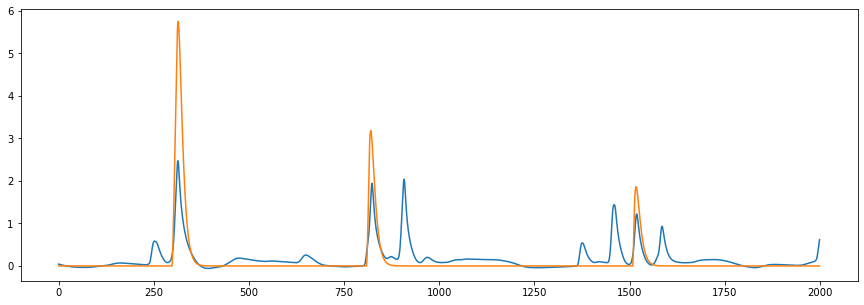

In [5]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000][2000:4000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000][2000:4000])
